In [1]:
get_ipython().run_line_magic('matplotlib', 'inline')
import os, sys

# sys.path.append("~/X/PythonForDataScience/air_traffic_project/submissions/first_real_submission/")

import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from problem import *
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
import geopy.distance
from sklearn.metrics import mean_squared_error
from model_selection_python import *
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os

from estimator import _merge_external_data
from keras.wrappers.scikit_learn import KerasRegressor

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
from keras.metrics import RootMeanSquaredError

from xgboost import XGBRegressor
import xgboost as xgb


pd.set_option('display.max_columns', None)

In [2]:
X_train, y_train = get_train_data('..')
X_test, y_test = get_test_data('..')

X_train_merged = _merge_external_data(X_train)
X_test_merged = _merge_external_data(X_test)

/Users/Hugo/Desktop/X-HEC/Polytechnique/Semestre 1/Python_For_Data_Science/air_traffic_project/src/external_data.csv


/Users/Hugo/Desktop/X-HEC/Polytechnique/Semestre 1/Python_For_Data_Science/air_traffic_project/src/estimator.py:38: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  X_encoded.loc[:, 'week'] = X_encoded['DateOfDeparture'].dt.week


/Users/Hugo/Desktop/X-HEC/Polytechnique/Semestre 1/Python_For_Data_Science/air_traffic_project/src/external_data.csv


In [5]:
X_test_merged.drop(['Departure', 'Arrival', 'holidays_dep', 'holidays_arr'], axis=1, inplace=True)
X_train_merged.drop(['Departure', 'Arrival', 'holidays_dep', 'holidays_arr'], axis=1, inplace=True)

In [10]:
dtrain = xgb.DMatrix(X_train_merged, label=y_train)
dtest = xgb.DMatrix(X_test_merged, label=y_test)

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}
params['eval_metric'] = "rmse"
num_boost_round = 999

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[0]	Test-rmse:7.39395
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:5.19554
[2]	Test-rmse:3.65814
[3]	Test-rmse:2.58859
[4]	Test-rmse:1.84891
[5]	Test-rmse:1.33731
[6]	Test-rmse:0.99322
[7]	Test-rmse:0.76299
[8]	Test-rmse:0.61792
[9]	Test-rmse:0.52786
[10]	Test-rmse:0.47763
[11]	Test-rmse:0.44988
[12]	Test-rmse:0.43286
[13]	Test-rmse:0.42463
[14]	Test-rmse:0.41951
[15]	Test-rmse:0.41580
[16]	Test-rmse:0.41313
[17]	Test-rmse:0.41167
[18]	Test-rmse:0.40911
[19]	Test-rmse:0.40898
[20]	Test-rmse:0.40860
[21]	Test-rmse:0.40336
[22]	Test-rmse:0.40156
[23]	Test-rmse:0.40100
[24]	Test-rmse:0.40037
[25]	Test-rmse:0.39999
[26]	Test-rmse:0.39880
[27]	Test-rmse:0.39821
[28]	Test-rmse:0.39716
[29]	Test-rmse:0.39652
[30]	Test-rmse:0.39644
[31]	Test-rmse:0.39651
[32]	Test-rmse:0.39681
[33]	Test-rmse:0.39619
[34]	Test-rmse:0.39465
[35]	Test-rmse:0.39431
[36]	Test-rmse:0.39340
[37]	Test-rmse:0.39307
[38]	Test-rmse:0.39157
[39]	Test-rmse:0.39156
[40]	Test-rmse:0.39118
[41]	Test-

In [11]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,7.399076,0.004260,7.400342,0.019154
1,5.197336,0.002960,5.199885,0.016418
2,3.657766,0.002067,3.661504,0.013678
3,2.583657,0.001497,2.590214,0.012140
4,1.835977,0.001056,1.847063,0.010694
...,...,...,...,...
94,0.140997,0.001834,0.379409,0.005507
95,0.139997,0.001901,0.379445,0.005494
96,0.138556,0.002094,0.379487,0.005503
97,0.137066,0.002145,0.379473,0.005537


In [13]:
cv_results['test-rmse-mean'].min()

0.3793874

In [22]:
%time

min_mae = float("Inf")
best_params = None

params['max_depth'] = 10
params['subsample'] = 1.0
params['colsample_bytree'] = 0.5

for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=42, nfold=8, metrics=['rmse'], early_stopping_rounds=10)
    # Update best score
    mean_mae = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 10 µs
CV with eta=0.3
CPU times: user 1min 35s, sys: 856 ms, total: 1min 36s
Wall time: 26.4 s
	RMSE 0.400261 for 146 rounds

CV with eta=0.2
CPU times: user 2min 34s, sys: 1.05 s, total: 2min 35s
Wall time: 41.4 s
	RMSE 0.377625875 for 256 rounds

CV with eta=0.1
CPU times: user 3min 57s, sys: 1.81 s, total: 3min 59s
Wall time: 1min 4s
	RMSE 0.356061625 for 387 rounds

CV with eta=0.05
CPU times: user 9min 42s, sys: 5.52 s, total: 9min 47s
Wall time: 2min 44s
	RMSE 0.3463305 for 975 rounds

CV with eta=0.01
CPU times: user 9min 54s, sys: 5.04 s, total: 9min 59s
Wall time: 2min 44s
	RMSE 0.34334437500000003 for 998 rounds

CV with eta=0.005
CPU times: user 9min 13s, sys: 4.17 s, total: 9min 17s
Wall time: 2min 32s
	RMSE 0.369807375 for 998 rounds

Best params: 0.01, MAE: 0.34334437500000003


In [36]:
params = {
    'max_depth': 10,
    'subsample': 1.0,
    'colsample_bytree': 0.5,
    'eta': 0.1,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:squarederror',
    'eval_metric': "rmse"
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:9.49167
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:8.54677
[2]	Test-rmse:7.69743
[3]	Test-rmse:6.93347
[4]	Test-rmse:6.24596
[5]	Test-rmse:5.62663
[6]	Test-rmse:5.07000
[7]	Test-rmse:4.56905
[8]	Test-rmse:4.11949
[9]	Test-rmse:3.71430
[10]	Test-rmse:3.35024
[11]	Test-rmse:3.02277
[12]	Test-rmse:2.72900
[13]	Test-rmse:2.46538
[14]	Test-rmse:2.22936
[15]	Test-rmse:2.01681
[16]	Test-rmse:1.82656
[17]	Test-rmse:1.65621
[18]	Test-rmse:1.50332
[19]	Test-rmse:1.36765
[20]	Test-rmse:1.24593
[21]	Test-rmse:1.13698
[22]	Test-rmse:1.03944
[23]	Test-rmse:0.95372
[24]	Test-rmse:0.87756
[25]	Test-rmse:0.80997
[26]	Test-rmse:0.74968
[27]	Test-rmse:0.69675
[28]	Test-rmse:0.65124
[29]	Test-rmse:0.61144
[30]	Test-rmse:0.57605
[31]	Test-rmse:0.54566
[32]	Test-rmse:0.51919
[33]	Test-rmse:0.49566
[34]	Test-rmse:0.47593
[35]	Test-rmse:0.45979
[36]	Test-rmse:0.44481
[37]	Test-rmse:0.43222
[38]	Test-rmse:0.42210
[39]	Test-rmse:0.41295
[40]	Test-rmse:0.40540
[41]	Test-

[344]	Test-rmse:0.34573
[345]	Test-rmse:0.34572
[346]	Test-rmse:0.34571
[347]	Test-rmse:0.34570
[348]	Test-rmse:0.34569
[349]	Test-rmse:0.34569
[350]	Test-rmse:0.34567
[351]	Test-rmse:0.34567
[352]	Test-rmse:0.34566
[353]	Test-rmse:0.34567
[354]	Test-rmse:0.34566
[355]	Test-rmse:0.34567
[356]	Test-rmse:0.34567
[357]	Test-rmse:0.34567
[358]	Test-rmse:0.34567
[359]	Test-rmse:0.34567
[360]	Test-rmse:0.34567
[361]	Test-rmse:0.34567
[362]	Test-rmse:0.34567
Stopping. Best iteration:
[352]	Test-rmse:0.34566



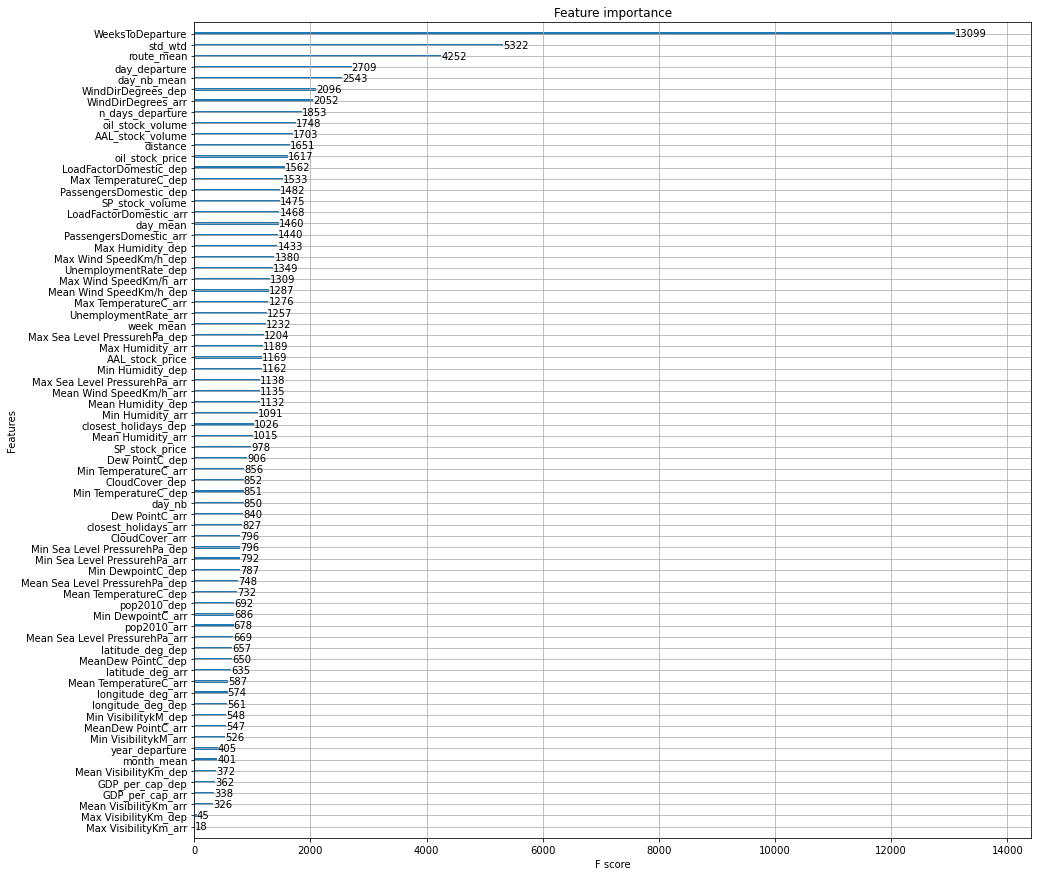

In [29]:
xgb.plot_importance(model)
# plt.rcParams['figure.figsize'] = [15, 15]
plt.show()